# In-pipe axial pico-hydraulic turbine dimensionless design method


## Library loading


In [2]:
#Install new version of matplotlib
!pip install matplotlib==3.3.4

     |████████████████████████████████| 11.6MB 318kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 10, 'pgf.rcfonts' : False})

import plotly.graph_objs as go

from scipy import interpolate, optimize

import pandas as pd
pd.option_context('display.precision', 2)

from ipywidgets import interactive_output, fixed, Layout
from ipywidgets import widgets as wdgts
from IPython.display import display

import os, io, pickle
from typing import Callable, List, Tuple

from google.colab import drive, widgets, output
drive.mount('/content/gdrive')

_=!find /content/gdrive -name mu0 -type d -printf '%p' -quit
_ =_[0]
%cd $_
%cd ../../

%cd extras/xfoil-python-master/
!pip install .
%cd ../../
from xfoil import XFoil
from xfoil.model import Airfoil

Mounted at /content/gdrive
/content/gdrive/MyDrive/Doctorado UPCT/Hidrogea/Paper0/Notebooks/extras/mu0
/content/gdrive/MyDrive/Doctorado UPCT/Hidrogea/Paper0/Notebooks
/content/gdrive/MyDrive/Doctorado UPCT/Hidrogea/Paper0/Notebooks/extras/xfoil-python-master
Processing /content/gdrive/MyDrive/Doctorado UPCT/Hidrogea/Paper0/Notebooks/extras/xfoil-python-master
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for xfoil: filename=xfoil-1.1.1-cp37-cp37m-linux_x86_64.whl size=287550 sha256=d1098bb35e7e36b63141fabd6b54f83309f45e008e5d9d062002532af71a91b5
  Stored in directory: /root/.cache/pip/wheels/b5/ea/cc/751ec3ca5a30d375c2444e357d0e07823c792fbed006789447
Successfully built xfoil
/content/gdrive/MyDrive/Doctorado UPCT/Hidrogea/Paper0/Notebooks


## Weinel model


The Weinel model function is declared below:
$$ C_L = \mu_0(1/\sigma,\gamma)\ C_{L0} \left( \frac{1 - \mu_1(1/\sigma,\gamma)\; C_{L0} \tan(\gamma)}{1 + \mu_1(1/\sigma,\gamma)\; C_{L0} \tan(\gamma)}\right) + 2\pi \mu_2(1/\sigma,\gamma)\; \sin(\alpha_{AOA}) 
$$

Where the coefficientes $\mu_0, mu_1, mu_2$ are function of the inverse of the solidity $\sigma$ and the stagger angle  $\gamma$

In [2]:
def WeinelCl(sigma:float, gamma:float, muCoef:List[Callable[[float,float],float]], Cl0:float, alphAOA:float) -> float:
    return ( muCoef[0](1/sigma, gamma) * Cl0 *
           ( 1 - muCoef[1](1/sigma, gamma) * Cl0 * np.tan( gamma*np.pi/180 ) ) / 
           ( 1 + muCoef[1](1/sigma, gamma) * Cl0 * np.tan( gamma*np.pi/180 ) ) +
           10*muCoef[2](1/sigma, gamma)*np.sin(alphAOA*np.pi/180)  ) 

### Weinel model coefficients


Weinel coefficients have been extracted from graphs in the bibliography and got interpolated as shown in the code of the follwing sub-sections.

#### Mu0

In [5]:
def mu0Fun() -> Callable[[float,float],float]:

    directory = './extras/mu0/'
    file = '0010152025303590.csv'
    
    smu0 = np.genfromtxt(directory+file,delimiter=',')
    
    g = [float(file[i:i+2]) for i in range(0,len(file[0:-4]),2) ]
    
    negind = np.where( np.diff(smu0[:,0]) < 0 )[0]
    first = negind[0]+1
    last = len(smu0[:,0])-1 -negind[-1]
    mid = np.diff(negind)
    
    first = [g[0]*np.ones(first)]
    last = [g[-1]*np.ones(last)]
    mid = [g[i+1]*np.ones(mid[i]) for i in range(len(mid))]
    
    g = np.hstack( tuple( first + mid + last ) )
    
    smu0g = np.hstack((smu0,g.reshape((len(g),1))))
    
    #Add first zero
    smu0g = np.vstack(( np.array([[0,0,0],]), smu0g ))
    
    #Add point at ifinity
    mu0inf = 1
    sInf = 21
    
    for i in range(len(negind)):
        index = negind[i]+2+i
        smu0g = np.insert(smu0g,index,[sInf, mu0inf, smu0g[index-1,2]], axis = 0)
        
    smu0g = np.append(smu0g,[[sInf, mu0inf, smu0g[-1,2]]], axis = 0)

    
    return interpolate.CloughTocher2DInterpolator(smu0g[:,0:3:2], smu0g[:,1])


#### Mu1

In [3]:
def mu1Fun() -> Callable[[float,float],float]:
    directory = './extras/mu1/'
    file = '0010152530405570.csv'
    
    smu1 = np.genfromtxt(directory+file,delimiter=',')
    
    g = [float(file[i:i+2]) for i in range(0,len(file[0:-4]),2) ]

    negind = np.where( np.diff(smu1[:,0]) < 0 )[0]
    first = negind[0]+1
    last = len(smu1[:,0])-1 -negind[-1]
    mid = np.diff(negind)
    
    first = [g[0]*np.ones(first)]
    last = [g[-1]*np.ones(last)]
    mid = [g[i+1]*np.ones(mid[i]) for i in range(len(mid))]
    
    g = np.hstack( tuple( first + mid + last ) )
    
    smu1g = np.hstack((smu1,g.reshape((len(g),1))))
    
    #Add point at ifinity
    mu1inf = 0
    sInf = 21
    sMid = 3.5      #Intermediete value of s
    muMidFac = 0.8      #factor of decay at smid
    muInfFac = 0.0005     #factor of decay at sInf
    
    for i in range(len(negind)):
        index = negind[i]+1+2*i
        inset = [ [sMid, smu1g[index-1,1]*muMidFac, smu1g[index-1,2]],
                  [sInf, smu1g[index-1,1]*muInfFac, smu1g[index-1,2]] ]
        
        smu1g = np.insert(smu1g,index,inset, axis = 0)
        
    inset = [ [sMid, smu1g[-1,1]*muMidFac, smu1g[-1,2]], 
              [sInf, smu1g[index-1,1]*muInfFac, smu1g[-1,2]] ]
    smu1g = np.append(smu1g,inset, axis = 0)
    
    #Add zero line for Gamma = 90º
    tLmin =  min(smu1g[:,0])
    inset = [[tLmin,0,90],[sInf,0,90]]
    smu1g = np.append(smu1g,inset, axis = 0)
 
    return interpolate.CloughTocher2DInterpolator(smu1g[:,0:3:2], smu1g[:,1])


#### Mu2

In [4]:
def mu2Fun() -> Callable[[float,float],float]:
    directory = './extras/mu2/'
    file = '0010152025306090.csv'
    
    smu2 = np.genfromtxt(directory+file,delimiter=',')
    
    g = [float(file[i:i+2]) for i in range(0,len(file[0:-4]),2) ]

    negind = np.where( np.diff(smu2[:,0]) < 0 )[0]
    first = negind[0]+1
    last = len(smu2[:,0])-1 -negind[-1]
    mid = np.diff(negind)
    
    first = [g[0]*np.ones(first)]
    last = [g[-1]*np.ones(last)]
    mid = [g[i+1]*np.ones(mid[i]) for i in range(len(mid))]
    
    g = np.hstack( tuple( first + mid + last ) )

    smu2g = np.hstack((smu2,g.reshape((len(g),1))))
    
    #Add point at ifinity
    mu2inf = 2*np.pi/10
    sInf = 21
    sMid = 3.9             #Intermediete value of s
    muMidFac = 0.8        #factor of decay at smid
    muInfFac = 0.0005     #factor of decay at sInf
    
    for i in range(len(negind)):
        index = negind[i]+1+2*i
        inset = [ [sMid, mu2inf *(1-muMidFac) + smu2g[index-1,1]*muMidFac, smu2g[index-1,2]],
                 [sInf, mu2inf *(1-muInfFac) + smu2g[index-1,1]*muInfFac, smu2g[index-1,2]] ]
        
        smu2g = np.insert(smu2g,index,inset, axis = 0)
        
    inset = [ [sMid, mu2inf *(1-muMidFac) + smu2g[-1,1]*muMidFac, smu2g[-1,2]], 
              [sInf, mu2inf *(1-muInfFac) + smu2g[-1,1]*muInfFac, smu2g[-1,2]] ]
    smu2g = np.append(smu2g,inset, axis = 0)
    
    
    return interpolate.CloughTocher2DInterpolator(smu2g[:,0:3:2], smu2g[:,1])

#### Plot  of the interpolating function of the coefficients

In [ ]:
def plotmu(fgamma:str, coefN:int, f:Callable[[float,float],float]) -> None:
    muLabel2D = [r"$\mu_0$", r"$\mu_1$", r"$2\pi\mu_2/10$"]
    muLabel3D = ["mu_0", "mu_1", "2*pi*mu_2/10"]
    plt.ioff()
    fig, ax = plt.subplots(figsize = [0.8*i for i in plt.rcParams["figure.figsize"]],
                          dpi = 100)
    gamma = [int(fgamma[i:i+2]) for i in range(0,len(fgamma),2)]
    sigma = np.linspace(1/3, 1/0.6, num=200)

    s, g = np.meshgrid(sigma, np.linspace(gamma[0], gamma[-1], num=200))
    mu = f(1/s, g)
    s[np.isnan(mu)]=np.nan
    g[np.isnan(mu)]=np.nan

    CF = ax.contourf(1/s, mu, g, levels=gamma)
    cb = plt.colorbar(CF, ax=ax, label=r'$\gamma\; (^{\circ})$')
    colorLvls = gamma.copy();  colorLvls[-1]-=0.001
    ax.contour(1/s, mu, g, colors='k', levels= colorLvls)
    ax.set(
        title = r'Coefficient $\mu_{:}$'.format(coefN),
        xlabel = r'$1/\sigma$',
        ylabel = muLabel2D[coefN],
        ylim = [0,2],
        xlim = [0.6,3]
    )
    fig = go.Figure(data=[go.Surface(x=1/s, y=g, z=mu, colorscale='Viridis' )])
    fig.update_layout(
        dragmode = 'orbit',
        autosize=False,  width=500, height=500,
        scene = dict(
        xaxis = dict(title = r'1/sigma'),
        yaxis = dict(title = r'gamma (°)'),
        zaxis = dict(title = muLabel3D[coefN]) 
        ),
        scene_camera = dict(
                 eye = dict(x=1.8,y=1.8,z=1.8)
        )
    )

    tab = widgets.TabBar(["2D plot", "3D plot"], location="bottom")
    with tab.output_to("3D plot"):
      fig.show()
    with tab.output_to("2D plot"):
      plt.show()

muCoeffFun = [
              ['0010152025303590',0,mu0Fun()],
              ['0010152530405570',1,mu1Fun()],
              ['0010152025306090',2,mu2Fun()]
]
def _():
  tab = widgets.TabBar(["mu"+str(i) for i in range(3)], location="top")
  for i in range(3):
    with tab.output_to(i):
      plotmu(*muCoeffFun[i])
_()


Output hidden; open in https://colab.research.google.com to view.

## Dimensionless chart

In the following subsections the code for solving and plotting the design variables of the rotor and stator cascades is shown. The systems to be solved are the following:
$$
 \left\lbrace 
 \begin{aligned}
   &\sigma_S(f)      \\
   &\alpha_m(f)      \\
   &\alpha_{AOA,S}(f) \\
 \end{aligned}
 \right. 
$$

$$
 \left\lbrace 
 \begin{aligned}
   &\sigma_R(f,\psi_u)      \\
   &\beta_m(f,\psi_u)      \\
   &\alpha_{AOA,R}(f,\psi_u) \\
 \end{aligned}
 \right. 
$$
Then from the mean flow angles and the angle of attack, the stagger angle of each cascade can be calculated as folllows:
$$ \gamma_S = \alpha_m - \alpha_{AOA,S} $$
$$ \gamma_R = \beta_m- \alpha_{AOA,R} $$

### Function to solve the system of equations of the relevant variables to the dimensionless desing chart

In [6]:
def DimensionlessDesignChartFunctions(Cl0S:float, Cl_optS:float, Cl0R:float, Cl_optR:float) -> Tuple[List[Callable[[float],float]], List[Callable[[float,float],float]]]: 
  # --- solution of the stator's cascade system of equations
  sigmaS = lambda f: 2/Cl_optS *1/np.sqrt(f**2 + 1/4) 
  alphm = lambda f: np.arctan(2*f)*180/np.pi
  aAOAS0 = 20
  mxItS = 40
  def alphaAOAS(f:float) -> float:
    try:
      return optimize.newton(lambda aAOA: Cl_optS - WeinelCl(sigmaS(f), alphm(f) - aAOA, 
                                                             [mu0Fun(), mu1Fun(), mu2Fun()], Cl0S, aAOA), aAOAS0, maxiter=mxItS)
    except:
      return np.nan
  alphaAOAS = np.vectorize(alphaAOAS)

  # --- solution of the rotor's cascade system of equations
  sigmaR = lambda f, psiU: 2/Cl_optR *1/np.sqrt(f**2 + (1/psiU - 1/2)**2) 
  betam = lambda f, psiU: np.arctan(f/(1/psiU - 1/2))*180/np.pi
  aAOAR0 = 2
  mxItR = 40
  def alphaAOAR(f:float, psiU:float) -> float:
    try:
      return optimize.newton(lambda aAOA: Cl_optR - WeinelCl(sigmaR(f, psiU), betam(f,psiU) - aAOA,
                                                             [mu0Fun(), mu1Fun(), mu2Fun()], Cl0R, aAOA), aAOAR0, maxiter=mxItR)
    except:
      return np.nan
  alphaAOAR = np.vectorize(alphaAOAR)

  return [sigmaS, alphm, alphaAOAS], [sigmaR, betam, alphaAOAR]


### Plot function of the dimensionless design chart

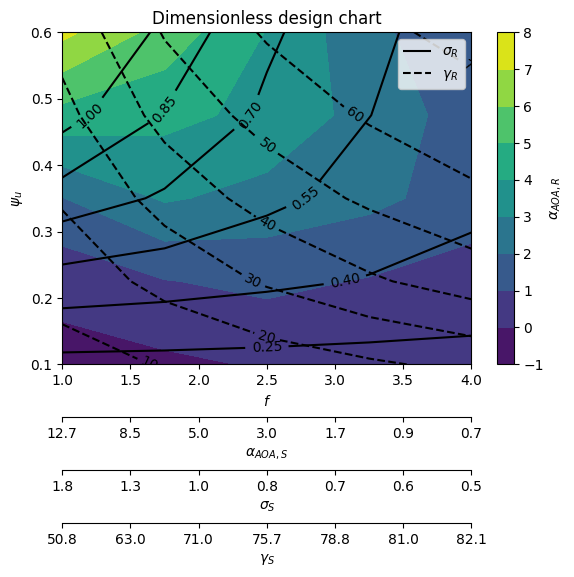

In [7]:
def DimensionlessDesignChartPlot(statorFun:List[Callable[[float],float]],
                                 fGrid:np.ndarray, psiUGrid:np.ndarray, rotorFunGrids:List[np.ndarray]) -> matplotlib.figure.Figure:
  # --- Recover function from arguments
  sigmaS, alphm, alphaAOAS = statorFun
  sigmaRG, betamG, alphaAOARG = rotorFunGrids
  gammaS, gammaRG = lambda f, aAOAS: alphm(f) - aAOAS,  betamG - alphaAOARG  
  
  # --- Dimensionless design chart: rotor's cascade contour plots ---
  plt.ioff()
  fig, ax = plt.subplots(figsize=[1.1*f*p for f,p in zip([1, 1], plt.rcParams["figure.figsize"])], dpi=100)
  ax.set(
      title = 'Dimensionless design chart',
      xlabel = r'$f$',
      ylabel = r'$\psi_u$'
      )

  f, psiU, aAOAR = fGrid, psiUGrid, alphaAOARG
  cAOAR = ax.contourf(f, psiU, aAOAR, zorder=0)
  cbAOAR = plt.colorbar(cAOAR, ax=ax, label=r'$\alpha_{AOA,R}$')
  cbAOAR.ax.zorder = -1
  ax.set_zorder(-2)

  cSigmaR = ax.contour(f, psiU, sigmaRG, colors='k', zorder=1, levels=np.linspace(0.25,1,6))
  plt.clabel(cSigmaR, inline=1, fontsize=10, fmt='%.2f')

  cGammaR = ax.contour(f, psiU, gammaRG, colors='k', linestyles='dashed', zorder=1)
  plt.clabel(cGammaR, inline=1, fontsize=10, fmt='%.0f')

  linesR  = [cSigmaR.collections[0], cGammaR.collections[0]] 
  labelsR = [r'$\sigma_R$', r'$\gamma_R$']
  ax.legend(linesR, labelsR)

  # --- Dimensionless design chart: stator's cascade horizontal axis representation ---
  fTickValues = ax.get_xticks()
  aAOAS = alphaAOAS(fTickValues) 
  varValues = [aAOAS, sigmaS(fTickValues), gammaS(fTickValues, aAOAS)]
  labelsS = [r'$\alpha_{AOA,S}$', r'$\sigma_S$', r'$\gamma_S$']

  for values,lbl,i in zip(varValues,labelsS,range(3)):
    axs = ax.twiny()
    val = ['{:.1f}'.format(tk) for tk in values]
    axs.set_xticks(fTickValues)
    axs.set_xticklabels(val)
    axs.xaxis.set_ticks_position('bottom') 
    axs.xaxis.set_label_position('bottom') 
    axs.spines['bottom'].set_position(('outward', (i + 1)*38))
    axs.set_xlabel(lbl)
    axs.set_xlim(ax.get_xlim())
    axs.spines['right'].set_visible(False)
    axs.spines['left'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.zorder = -1
  return fig

def _():
  fRange, psiURange, gridRes = [1, 4], [0.1, 0.6], 5
  fG, psiUG = np.meshgrid(np.linspace(*fRange, gridRes), np.linspace(*psiURange, gridRes))
  statorF, rotorF = DimensionlessDesignChartFunctions(1, 1, 1, 1)
  fig = DimensionlessDesignChartPlot(statorF, fG, psiUG, [f(fG,psiUG) for f in rotorF])
  for f in plt.get_fignums()[:-1]:
    plt.close(f)
  plt.show()
  
_()

## The design algorithm

On the following subsections the design algorithm along with the design example are laid out.

### 1.- Selection of design parameters

The input parameters to the design must be selected so that they can be obtained from the dimensionless parameters:

$$ \psi_u=\frac{g H_u}{U^2}; \; f=\frac{\phi}{\psi_u}\; \text{given: } \phi=\frac{C_a}{U}$$

The minimal set of parameters are $H_u$, $U$, $C_a$; i.e.: one dynamic parameter and two kinematics. More practical set of parameters are: 
* Three operational parameters: 
    * The flow rate $Q$
    * The useful head $H_u$ or the head $H$ or the mechanical power $\dot{W}$. Given the efficiency equations $\eta_h = \frac{\dot{W}}{\rho g H Q} = \frac{H_{3D}}{H}$ and $\eta_{3D}=\frac{H_{3D}}{H_u}$. Estimation of the efficiencies are given: $\eta_h \approx 0.7$ and $\eta_{3D}\approx 0.65$
    * The angular speed $n$
* Two geometrical parameters that define the annular passage of the turbine:
    * The pipe size ($D_p$ or $R_p$), or the hub size ($D_h$ or $R_h$)
    * Given the previus one, the other element size (pipe or hub). Or a dimensionless meaningful variable like the hub-to-tip ratio $T=\frac{R_h}{R_p}$ or the area factor $f_A = \frac{A_\text{pipe}}{A_\text{annular passage}} = \frac{R_p^2}{R_p^2 - R_h^2}$


For the design example, a turbine is designed around the values of the best efficiency point of a tested published propeller pico turbine[*], the following five practical parameters are chosen: $Q$, $H$, $n$, $R_p$ and $f_A$
* The flow rate is chosen to be $Q=16^3/h$ as in the BEP of the reference turbine
* The head is to be fixed $H=0.34m$ as as in the BEP of the reference turbine. The useful head is therefore $H_u \approx 0.37m$
* The angular is chosen to be a soft (variable) constraint $n=500-1500rpm$
* The pipe radius is set to be fixed $R_p = 0.0425m$ as the design constraint on the reference turbine
* The area factor is chosen to be a soft (variable) constraint $f_A = 2-3$

[*] I. Samora, V. Hasmatuchi, C. Münch-Alligné, M. J. Franca, A. J. Schleiss, and H. M. Ramos, “Experimental characterization of a five blade tubular propeller turbine for pipe inline installation,” Renewable Energy, vol. 95, pp. 356–366, 2016. 

### 2.- Selection of stator and rotor airfoils

Each of the airfoils of the rotor and stator cascade can be obtained using various criteria, among them:
- Highest $C_L/C_D$ for a given Reynolds number or range of them.
- High tolerance to turbulence (little change in $C_L/C_D$ behaviour in a wide range of turbulence conditions)
- Ease of manufacturing

From the selected airfoils, the ($C_{L0}$, $C_{L,\textrm{opt}}$) pair         can be obtained, which is necesary to obtain the dimensionless design chart.

For this work the criteria utilized were:
- Shape: arc of circles for ease of manufacturing
- The camber that gives maximum $C_L/C_D$ for the mean value of the Reynolnds number on the design space at mean radius.
- Blade thickness $\geq$1mm
- To garantee structural robustness the aspect ratio is set to $\text{ar}=(R_p-R_h)/l\approx0.6$

To chose airfoils for the stator and rotor cascades that meet the criteria a study is made with xFoil, for that matter the relative thickness, the mean Reynolds number on design space, and turbulent transition criteria are must be previusly calculated as follow:


- Given the aspect ratio criterion and the input parameters, the design space of the chord legth can be calculated: $l = R_p(1-\sqrt{1-1/f_A})/\text{ar}$. From the chord length space, the minimum relative thickness that meet the criterion can be calculated.


In [ ]:
def _(Rp, fA, ar, thk):
  l = Rp*(1 - np.sqrt(1 - 1/fA))/ar
  relThk = np.max(thk/l)
  print(r"The chord length design space is: l = " +
        f"{l[1]*1000:.0f} - {l[0]*1000:.0f} mm")
  print(r"The minimum relative thickness that meets the criterion is: thk/l = "+
        f"{relThk:.2f}")

_(0.0425, np.array([2, 3]), 0.6, 0.001)

The chord length design space is: l = 13 - 21 mm
The minimum relative thickness that meets the criterion is: thk/l = 0.08


- The design space of the Reynolds number at mean radius of the stator and rotor can be calculated as follows respectively: $\mathrm{Re}_S \approx C_a l_S/\nu = Q/(\pi(R_p^2-R_h^2)) l_S/\nu = Q/(\pi R_p^2)f_A l_S/\nu$; $\mathrm{Re}_R \approx \omega R_m l_R/\nu  = \omega R_p(1+R_h/R_p)/2 \; l_R/\nu =  \omega R_p \left(1+\sqrt{1-1/f_A}\right)/2 \; l_R/\nu$. 


In [ ]:
def _(Q, Rp, n, fA, l):
  nu = 1e-6
  ReS = Q/(np.pi*Rp**2)*fA*l/nu
  ReR = n/30*np.pi*Rp*(1 + np.sqrt(1-1/fA))/2*l/nu
  print(f"Stator average Reynolds number at mean radius: Re = {np.sum(ReS)/2:.1e}")
  print(f"Rotor  average Reynolds number at mean radius: Re = {np.sum(ReR)/2:.1e}")
_(16/3600, 0.0425, np.array([500,1500]), np.array([2,3]), np.array([0.013, 0.021]))

Stator average Reynolds number at mean radius: Re = 3.5e+04
Rotor  average Reynolds number at mean radius: Re = 7.6e+04


- The arithmetic mean of the turbulence intensity $I_p$ on the pipe upstream is used as reference to determine the turbulence transition criterion. It can be calculated as follows:  $I=0.277 \mathrm{Re}_p^{-0.1}$, where $\mathrm{Re}_p$ is the Reynolnds number of the pipe.

In [ ]:
def _(Q, Rp):
  I = 0.277*(Q/(np.pi*Rp**2)*2*Rp/1e-6)**-0.1
  print(f"Calculated turbulence intensity I = {I*100:.1f}%")
_(16/3600, 0.0425)

Calculated turbulence intensity I = 9.1%


- The calculated reference mean flow turbulence is very high, indicating that bypass turbulence transition is the main boundary layer transition mechanism. On this case, xFoil recommends to manually set the relative chord distance where the laminar to turbulent transition happens, from the litterature[*], it can be estimated that for the turbulence intensity and Reynolds numbers involved, the turbulence transition point can be set to  $\mathrm{xtr}/l = 0.01$.

[*]V. Chernoray, “Prediction of laminar-turbulent transition on an airfoil at high level of free-stream turbulence,” Progress in Flight Physics – Volume 7, 2015. 



#### Airfoil generator function (XFOIL input)

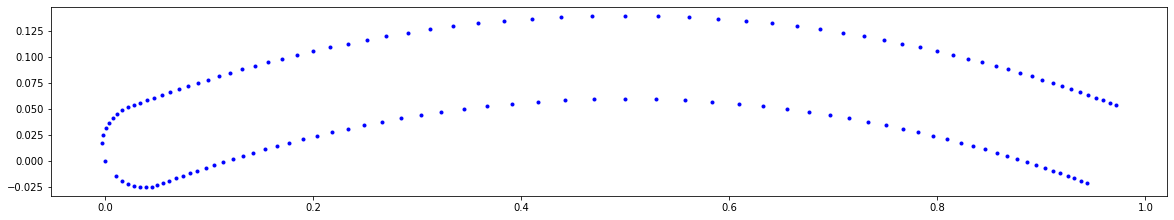

In [8]:
def airfoilArc(h:float) -> Tuple[np.ndarray, np.ndarray]:
  nInExPts = 80
  thk = .08    

  c = 1
  R = h/2 + c**2/(8*h)
  xc = 0.5
  yc = -R + h

  xml = lambda tht: R*np.cos(tht) + xc
  yml = lambda tht: R*np.sin(tht) + yc
  Dtht = 4*np.arctan(2*h/c)
  tht0 = np.pi/2 - Dtht/2

  t = lambda s: np.piecewise(s,
      [ 
       s < thk/2,
       (thk/2 <= s) & (s <= 1-thk/2),
       s > 1-thk/2
      ],
      [
       lambda s: np.sqrt((thk/2)**2 - (thk/2 - s)**2),
       lambda s: thk/2,
       lambda s: np.sqrt((thk/2)**2 - (s -1 +thk/2)**2)
      ]
  )
  s = lambda tht: (tht-tht0)/Dtht

  dydx = lambda tht: -1/np.tan(tht) 
  alph = lambda tht: np.arctan(dydx(tht))

  # --- Upper=> sign = +1: Lower=> sign = -1
  xUL = lambda tht, sign: xml(tht) - sign*t(s(tht))*np.sin(alph(tht))
  yUL = lambda tht, sign: yml(tht) + sign*t(s(tht))*np.cos(alph(tht))
  
  THT = (np.geomspace(1,8, int(nInExPts/2)) - 1)/(8-1)/2
  THT = np.hstack((THT[THT>=thk/2], 1 - THT[-2::-1]))*Dtht +tht0
  THT = np.hstack((THT, -THT[-2::-1]))
  x = xUL(np.abs(THT), np.sign(THT))
  y = yUL(np.abs(THT), np.sign(THT))
  return (x,y)

def _():
  fig,ax = plt.subplots(figsize=[20,20])
  ax.plot(*airfoilArc(0.1), 'b.')
  ax.set_aspect('equal')
  plt.show()

_()

#### Parametric study and selection of airfoil camber with xFoil

##### Parametric analysis function

In [9]:
def xFoilStudy(Re:float, xtr:float) -> Tuple[np.array,np.array,np.array,np.array]:
  xf = XFoil()
  h = np.linspace(0.01,0.13,13)

  a,cl,cd = 3*[np.array([])]
  for hi in h:
    x,y = airfoilArc(hi)
    xf.airfoil = Airfoil(x,y)
    xf.repanel()
    xf.Re = Re
    xf.xtr = 2*[xtr]
    a,cl,cd =[np.hstack((x,xi)) for x,xi in zip([a,cl,cd], xf.aseq(0,20,0.2))]

  h = (np.zeros(int(len(a)/len(h))) + h.reshape(-1,1)).flatten()
  notNAN = ~np.isnan(cl/cd)
  h,a,cl,cd = [arr[notNAN] for arr in [h,a,cl,cd]]
  return (h,a,cl,cd)

xFStS,xFStR = xFoilStudy(3.5e4, 0.1),xFoilStudy(7.6e4, 0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in sqrt



##### Dynamic plot for airfoil selection


In [10]:
def _():
  def iPlot(ai, hi, xFSt):
    alim, hlim = [0,10], [0.01,0.13]
    h,a,cl,cd = xFSt
    fig,[ax0,ax1] = plt.subplots(1,2, figsize=[10,5], sharey=True, dpi=100)

    hm,am = np.meshgrid(np.linspace(*hlim),np.linspace(*alim))
    clCdInterp = interpolate.LinearNDInterpolator(list(zip(h,a)), cl/cd)
    clCdm = clCdInterp(hm,am) 
    ax1.vlines(hi,ai,alim[0], color='k', linestyle='dashed')

    lvls = np.linspace(np.nanmin(clCdm),np.nanmax(clCdm), 11)
    lvls = np.hstack((lvls[lvls<0.85*lvls[-1]],[0.9*lvls[-1],lvls[-1]]))
    cf = ax1.contourf(hm, am, clCdm, zorder=0, levels=lvls)
    cb = plt.colorbar(cf, ax=ax1, label=r'$C_L/C_D$') 
    ax1.contour(hm, am, clCdm, colors='k', levels=lvls)
    ax1.plot(hi, ai, 'ro')
    ax1.hlines(ai,hi,hlim[0], color='k', linestyle='dashed')
    ax1.set(
        xlabel='$h/l$'
    )

    aLine = np.linspace(*alim)
    clInterp = interpolate.LinearNDInterpolator(list(zip(a,h)), cl)
    ax0.plot(clInterp(aLine,hi), aLine)

    cli,cl0 = clInterp(ai,hi), clInterp(0,hi)
    fig.suptitle(r"Selected airfoil: $C_{L,0}$ = "+f"{cl0:.2f} "+
                 r"$C_{L,\mathrm{opt}}$ = "+f"{cli:.2f}", size="x-large")

    ax0.vlines(cli, ai, alim[0], color='k', linestyle='dashed')
    ax0.plot(clInterp(ai,hi), ai, 'ro')
    ax0.set_xlim(ax0.get_xlim())
    ax0.hlines(ai,*ax0.get_xlim(), color='k', linestyle='dashed')
    ax0.set(
       xlim = ax0.get_xlim(), 
       xlabel = r'$C_L$',
       ylabel = r'$\alpha_{AOA}$'
    )
    plt.show()

  tab = widgets.TabBar(["xFoil study for the "+s for s in ['stator','rotor']], location="top")
  for i, xFSt in zip(range(2), [xFStS, xFStR]):
    with tab.output_to(i):
      hi = wdgts.FloatSlider(min=0.01,max=0.13, step=0.005, value=0.07, 
                               description='Airfoil camber "h"', readout_format='.3f',
                               style={'description_width':'200px'}, layout=Layout(width='600px'))
      ai = wdgts.FloatSlider(min=0,max=10, step=0.1, value=3, 
                               description='Angle of attack (deg)', readout_format='.1f',
                               style={'description_width':'200px'}, layout=Layout(width='600px'))
      interPlot = interactive_output(iPlot, {'xFSt':fixed(xFSt), 'hi':hi, 'ai':ai})
      ui = wdgts.VBox([
                       interPlot,
                       wdgts.VBox([hi,ai]) 
                      ])
      display(ui)
_()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To select the camber of the arc of circle airfoil, the dynamic plot is used. The top contour line is set so that $C_L/C_D > 0.9(C_L/C_D)_\mathrm{max}$. As an extra selection criterion the airfoil with a camber that have the most angle of attack range with $C_L/C_D$ above 90% of the maximum is selected. The optimal lift coefficient is selected so that is on the 90% plateau and is closer to the lower limit of the plateu than the upper, so it allows better operation when heavily loaded.

For this work the selecte airfoils and its correspondig lift coefficients where the following:
- Stator airfoil: camber 7.5%, $\;C_{L,0} = 0.64$,  $\;C_{L,\mathrm{opt}} = 1.27$ 
- Rotor airfoil: camber 8.5%, $\;C_{L,0} = 0.79$,  $\;C_{L,\mathrm{opt}} = 1.11$ 

### 3.- Turbine selection from the dimensionless design chart with design space contours

To select the best turbine design given the design conditions, the design space contours for the soft constraints must be plotted on the dimensionless design chart. From the design space, a turbine that meets the following criteria is selected:
- Lowest angle of attack on both stator and rotor cascades. (Assuring to unload the turbine as much as possible)
- Solidity criterion: $\sigma > 0.25$ 
- As reference, the usual specific speed for propellers [*] can be met too: $\Omega_s = \omega Q^{1/2}/(g H)^{3/4} =  (n\;\pi/30)Q^{1/2}/(g H_u (\eta_h/\eta_\mathrm{3D}))^{3/4} $. For propellers $\Omega_s \in \{2,3\}$

[*] S. L. Dixon and C. A. Hall, Fluid mechanics and thermodynamics of turbomachinery. Kidlington, Oxford, UK: Butterworth-Heinemann, 2014. 

#### Dynamic plot of the dimensionless design chart with the design space for the turbine selection

On this work, the soft constraints or variable parameters of choice are $n$ and $f_A$. To get the contours of both variables, the following parametric surfaces were plotted:
$$
 \left\lbrace 
 \begin{aligned}
   &x = f(n,f_A) = \left(\frac{Q}{2\pi R_p g H_u}\right)\left(\frac{n\;\pi/30}{1-\sqrt{1-1/f_A}}\right)     \\
   &y = \psi_u(n, f_A) = \left(\frac{4 g H_u}{R_p^2}\right)\left(\frac{1}{(n\;\pi/30)^2(1+\sqrt{1-1/f_A})^2}\right)      \\
   &z = n \;\;\mathrm{or}\;\; z = f_A \\
 \end{aligned}
 \right. 
$$

In [16]:
def _():
  # --- Pre generate input data for dimenisonless desing chart
  fRange, psiURange, gridRes = [0.8, 4], [0.05, 1], 15
  fG, psiUG = np.meshgrid(np.linspace(*fRange, gridRes), np.linspace(*psiURange, gridRes))
  statorF, rotorF = DimensionlessDesignChartFunctions(Cl0S=0.64, Cl_optS=1.27, Cl0R=0.79, Cl_optR=1.11)
  rotorFG = [f(fG,psiUG) for f in rotorF]

  # --- Definition of design space parametric functions
  fParamF = lambda n, fA: Q*(np.pi/30*n) / (2*np.pi*(1 - np.sqrt(1-1/fA)) *Rp*g*Hu)
  psiUParamF = lambda n, fA: 4*g*Hu/((np.pi/30*n)**2 *Rp**2 *(1 + np.sqrt(1-1/fA))**2)
  nRange = [500,1500]
  fARange = [2, 3]
  g = 9.81
  Hu = 0.37
  Q = 16/3600
  Rp = 0.0425
  etah = 0.7
  eta3D = 0.65
  nPoints = 20
  n, fA = np.meshgrid(np.linspace(*nRange, nPoints), np.linspace(*fARange, nPoints))
  fPG = fParamF(n, fA)
  psiUPG = psiUParamF(n, fA)

  # --- Pre-generate background figure
  fig = DimensionlessDesignChartPlot(statorF, fG, psiUG, rotorFG)
  for f in plt.get_fignums()[:-1]:
    plt.close(f)
  ax = fig.axes[0]
  fig.suptitle("Dimensionless design chart with dynamic exploration of design space")
  cn = ax.contour(fPG, psiUPG, n, colors='w',
                  linestyles='dotted', zorder=1, levels=[500,750,1000,1500-0.01])
  plt.clabel(cn, inline=1, fontsize=10, fmt='%.0f')

  cfA = ax.contour(fPG, psiUPG, fA, colors='w',
                  linestyles='dashed', zorder=1, levels=[2,3-0.01])
  plt.clabel(cfA, inline=1, fontsize=10, fmt='%.1f')
                  
  NSF = lambda n: (n*np.pi/30)*Q**(1/2)/(g*Hu*(etah/eta3D))**(3/4) 
  NSG = NSF(n)
  cNS = ax.contour(fPG, psiUPG, NSG, colors='w', zorder=1, levels=[1.5, 2, 3])
  plt.clabel(cNS, inline=1, fontsize=10, fmt='%.1f')
  
  linesP  = [cn.collections[0], cfA.collections[0], cNS.collections[0]] 
  labelsP = [r'$n \;(\mathrm{rpm})$', r'$f_A$', r'$\Omega_s$']
  lgnd = plt.legend(linesP, labelsP, loc='lower left', framealpha=0.3)


  # --- Copy figure for later use
  buf = io.BytesIO()
  pickle.dump(fig, buf)
  plt.close(fig)

  # --- Plotting function to make it dynamic
  def iPlot(ni, fAi):
    # --- get static figure and axes
    buf.seek(0)
    figN = pickle.load(buf) 
    ax = figN.axes[0]

    # --- Plot of the selected point on design space
    fi = fParamF(ni,fAi)
    psiUi = psiUParamF(ni,fAi)
    f0 = ax.get_xlim()[0]
    psiU0 = ax.get_ylim()[0]
    ax.plot(fi, psiUi, 'r.', zorder=20)
    ax.hlines(psiUi, fi, f0, color='gray', linestyle='dashdot')
    ax.vlines(fi, psiUi, psiU0, color='gray', linestyle='dashdot')

    # --- Title with the obtained design variable
    sigmaSi, alphmi, alphaAOASi = [fun(fi) for fun in statorF]
    sigmaRi, betami, alphaAOARi = [fun(fi, psiUi) for fun in rotorF]
    sS, gS, sR, gR, NS = sigmaSi, alphmi - alphaAOASi, sigmaRi, betami - alphaAOARi, NSF(ni)
    ax.set_title(r"$\sigma_S=$" + f"{sS:.2f}; "+
                 r"$\gamma_S=$" + f"{gS:.1f}°; "+
                 r"$\sigma_R=$" + f"{sR:.2f}; "+
                 r"$\gamma_R=$" + f"{gR:.1f}° "+
                 "for " +
                 r"$f=$"        + f"{fi:.1f} "
                 r"$\psi_u=$"   + f"{psiUi:.2f} "
                 r"$\Omega_s=$" + f"{NS:.1f} "
                 )
    plt.show()

  # --- Setup of dynamic plot
  ni = wdgts.FloatSlider(min=nRange[0], max=nRange[1], step=10, value=np.sum(nRange)/2, 
                               description='Angular speed (rpm)', readout_format='.0f',
                               style={'description_width':'200px'}, layout=Layout(width='600px'))
  fAi = wdgts.FloatSlider(min=fARange[0],max=fARange[1], step=0.1, value=np.sum(fARange)/2, 
                               description='Area factor', readout_format='.1f',
                               style={'description_width':'200px'}, layout=Layout(width='600px'))
  interPlot = interactive_output(iPlot, {'ni':ni, 'fAi':fAi})
  ui = wdgts.VBox([
                       wdgts.VBox([ni,fAi]) ,
                       interPlot
                      ]) 
  display(ui)

_()

The design that fulfilled all restrictions and criteria is summarized bellow:
- Stator cascade geometric dimensionless parameters: solidity $\sigma_S=0.72$, stagger angle $\gamma_S = 67.6°$
- Stator blade profile: arc of circle with relative thickness of 8% and camber of 7.5%
- Rotor cascade geometric dimensionless parameters: solidity $\sigma_R=0.41$, stagger angle $\gamma_R = 26.0°$
- Rotor blade profile: arc of circle with relative thickness of 8% and camber of 8.5%
- Soft constraints: angular speed $n=1000$rpm, area factor $f_A=2.5$
- Hard constraints: $Q=16\mathrm{m}^3/\mathrm{s}$, $H=0.34$m, $R_p=0.0425$m
- Reference specific speed: $\Omega_s=2.5$

### 4.- Setting of cascades dimensions and final geometry

The turbine pasage geometry is completely defined if both pipe and hub sizes are selected as constraints, otherwise, with the relevant dimensionless constraint defined, the correspondig size that defines the passage can be calculated

The only parameters yet to be defined to completly describe the cascades are the chord length and the number of blades, which can be set given the following criteria:
- The number of blades of the stator and rotor is recommended to be a coprime number, minimizing this way the stator wake's shadowing on the rotor cascade
- Given a mechanical criteria on the minimum chrod length or a geometrical constraint on aspect ratio.

On this work, the geometrical constraint where the pipe radius $R_p$ and the area factor$f_A$. From the area factor the hub radius $R_h$ can be found as follows:
$$ f_A = \frac{R_p^2}{R_p^2-R_h^2} \Rightarrow R_h = R_p\sqrt{1 - 1/f_A} = 0.0329\mathrm{m}$$

To completly define the cascades, the following criteria are followed:
- Number of stator and rotor blades to be coprime, i.e. the greater common divisor (gcd) must be equal to one
- Given that for the airfoil study, the aspect ratio is assumed to be $\mathrm{ar}\approx0.6$, the pair of stator and rotor blade number who results in a aspect ratio closer but bigger to that criterion is chosen. 

This can be expressed by the following system:
$$
 \left\lbrace 
 \begin{aligned}
   &Z_{S,R} = \frac{\sigma_{S,R}\pi(R_p+R_h)}{l_{S,R}} \\
   &\mathrm{gcd}(Z_S,Z_R)=1     \\
   &\mathrm{ar}=\frac{R_p-R_h}{l}\geq 0.6 
 \end{aligned}
 \right.
$$


The following code solves the system to get the pairs of number of blades so that the chord legths aspec ratio are closer to the unity as stated by the previus system.

In [ ]:
def bladeDimensions(sigmaS:float, sigmaR:float, Rp:float, Rh:float, ar:float) -> Tuple[List[float],List[float]]:
  l = lambda z,s: s*np.pi*(Rp+Rh)/z 
  dR = Rp-Rh
  def fun(Z):
    lS = l(Z[0],sigmaS)
    lR = l(Z[1],sigmaR)
    if np.gcd(Z[0],Z[1]) != 1 or dR/lS<ar or dR/lR<ar:
      return np.infty
    return (dR/lS -ar)**2 + (dR/lR -ar)**2
  ZS0 = int(sigmaS*np.pi*(Rp+Rh)/dR*ar) +1
  ZR0 = int(sigmaR*np.pi*(Rp+Rh)/dR*ar) +1
  ZSpace = (slice(int(ZS0*0.5)+1, int(ZS0*1.5)+1,1), slice(int(ZR0*0.5)+1, int(ZR0*1.5)+1,1))
  res = optimize.brute(fun, ZSpace, finish=None)
  ZS,ZR = res 
  lS, lR = l(ZS,sigmaS), l(ZR,sigmaR)
  return ([ZS, lS], [ZR, lR])

def _():
  Rp, Rh = 0.0425, 0.0329
  [ZS, lS], [ZR, lR]= bladeDimensions(0.72, 0.41, Rp, Rh, 0.6)
  arS = (Rp-Rh)/lS
  arR = (Rp-Rh)/lR
  print(f"Stator: Z = {int(ZS)}, l = {lS:.4f}m, ar = {arS:.2f}")
  print(f"Rotor : Z = {int(ZR)}, l = {lR:.4f}m, ar = {arR:.2f}")
_()


Stator: Z = 11, l = 0.0155m, ar = 0.62
Rotor : Z = 7, l = 0.0139m, ar = 0.69
